# NBA Scoring & 3‑Point Evolution (1950–2024)

**Goal:** Explore how scoring and three-point shooting have changed from the early NBA era to the modern game, and project where the game is heading.

**What you'll need:** The CSV from the dataset *“NBA Player Stats 1950–2024”* (e.g., from Kaggle). Place it anywhere accessible and paste its file path below.

**Outputs in this notebook:**
- Cleaned and aggregated metrics by season
- Visualizations of scoring and 3PT trends
- Simple projections for "where the game is going" based on recent trends

> Note: This notebook uses pandas, numpy, matplotlib, and scikit-learn only.

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


## 1) Load dataset
Paste the full path to your CSV (from the *NBA Player Stats 1950–2024* dataset). If the dataset has multiple files, use the one that contains per-season or per-player per-season stats with columns like `Year`, `G`, `PTS`, `FG3A`, `FG3M`, `FG3_PCT` (column names may vary).

In [11]:

# === EDIT THIS: set your CSV path ===
csv_path = input("Enter path to your NBA Player Stats CSV: ").strip()

if not csv_path:
    raise SystemExit("No CSV path provided. Re-run and paste the full path to your dataset.")

csv_path = Path(csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"Could not find file at {csv_path}. Please check the path and try again.")

# Try reading
df_raw = pd.read_csv(csv_path)
print("Loaded shape:", df_raw.shape)
display(df_raw.head(3))
print(df_raw.columns.tolist())


Loaded shape: (24691, 53)


,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0


['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


## 2) Basic cleaning & normalization
We’ll try to standardize common column names used across NBA stat datasets.
- Ensure `Year` exists (as a number like 1950–2024)
- Ensure `G` (games), `PTS` (points), `FG3A` (3PA), `FG3M` (3PM), `FG3_PCT` (3P%) if present
- Compute per-game figures where possible
- Aggregate by year (mean across players)

If some columns are missing (e.g., early eras had no 3PT stats), we’ll handle gracefully.

In [12]:

df = df_raw.copy()

# Standardize likely column names
# Try to map alternatives if common variants exist
rename_map_candidates = [
    {'season':'Year','Season':'Year','year':'Year'},
    {'GP':'G','GamesPlayed':'G'},
    {'3PA':'FG3A','3PM':'FG3M','3P%':'FG3_PCT','FG3%':'FG3_PCT','three_point_percentage':'FG3_PCT'},
    {'Points':'PTS','PTS_per_game':'PTS_per_game'}
]
for m in rename_map_candidates:
    for a,b in m.items():
        if a in df.columns and b not in df.columns:
            df = df.rename(columns={a:b})

# Ensure Year numeric
if 'Year' not in df.columns:
    # Some datasets use 'season' like 1996-97; extract final year as numeric
    for candidate in ['Season', 'season']:
        if candidate in df.columns:
            def season_to_year(x):
                if isinstance(x, str) and '-' in x:
                    try:
                        return int(x.split('-')[-1]) + 1900 if len(x.split('-')[-1])==2 else int(x.split('-')[-1])
                    except:
                        return np.nan
                try:
                    return int(x)
                except:
                    return np.nan
            df['Year'] = df[candidate].map(season_to_year)
            break
# Coerce Year to integer if possible
df['Year'] = pd.to_numeric(df.get('Year', np.nan), errors='coerce')
df = df.dropna(subset=['Year']).copy()
df['Year'] = df['Year'].astype(int)

# Ensure core numeric columns exist (create if missing to avoid errors)
for c in ['G','PTS','FG3A','FG3M','FG3_PCT']:
    if c not in df.columns:
        df[c] = np.nan

# Per-game stats
with np.errstate(divide='ignore', invalid='ignore'):
    df['PTS_per_game'] = df['PTS'] / df['G']
    df['3PA_per_game'] = df['FG3A'] / df['G']
    df['3PM_per_game'] = df['FG3M'] / df['G']

# Some rows may have inf or unrealistic values when G=0; replace with NaN
for c in ['PTS_per_game','3PA_per_game','3PM_per_game']:
    df.loc[~np.isfinite(df[c]), c] = np.nan

# Aggregate by year (mean across all players with valid stats)
agg = df.groupby('Year').agg({
    'PTS_per_game':'mean',
    '3PA_per_game':'mean',
    '3PM_per_game':'mean',
    'FG3_PCT':'mean'
}).reset_index()

# Some early years pre-1979 will have NaN for 3PT columns; fill with 0 where appropriate
# Note: 3PT line introduced in 1979-80 NBA season.
agg['3PA_per_game'] = agg['3PA_per_game'].fillna(0.0)
agg['3PM_per_game'] = agg['3PM_per_game'].fillna(0.0)
# Keep FG3_PCT NaN for years before 1979 to be accurate; we can forward-fill for plotting if desired
agg_ffill = agg.copy()
agg_ffill['FG3_PCT'] = agg_ffill['FG3_PCT'].fillna(method='ffill')

print("Aggregated by year:", agg.shape)
display(agg.head(10))

# Save processed aggregates for the Streamlit app
out_csv = Path("/mnt/data/nba_scoring_3pt_evolution/agg_by_year.csv")
agg.to_csv(out_csv, index=False)
print("Saved yearly aggregates to:", out_csv)


Aggregated by year: (68, 5)


C:\Users\resol\AppData\Local\Temp\ipykernel_23732\1868280928.py:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg_ffill['FG3_PCT'] = agg_ffill['FG3_PCT'].fillna(method='ffill')


,Year,PTS_per_game,3PA_per_game,3PM_per_game,FG3_PCT
0,1950,6.603313,0.0,0.0,NaN
1,1951,7.259843,0.0,0.0,NaN
2,1952,7.943562,0.0,0.0,NaN
3,1953,7.322403,0.0,0.0,NaN
4,1954,7.034638,0.0,0.0,NaN
5,1955,8.146223,0.0,0.0,NaN
6,1956,8.943393,0.0,0.0,NaN
7,1957,9.000575,0.0,0.0,NaN
8,1958,9.117885,0.0,0.0,NaN
9,1959,9.926581,0.0,0.0,NaN


OSError: Cannot save file into a non-existent directory: '\mnt\data\nba_scoring_3pt_evolution'

## 3) Visualize long-term trends
We’ll plot average **points per game (PPG)** and **3PT usage** (3PA & 3PM per game), plus average **3P%**.

**Note:** We use plain matplotlib (no specific colors set) as required.

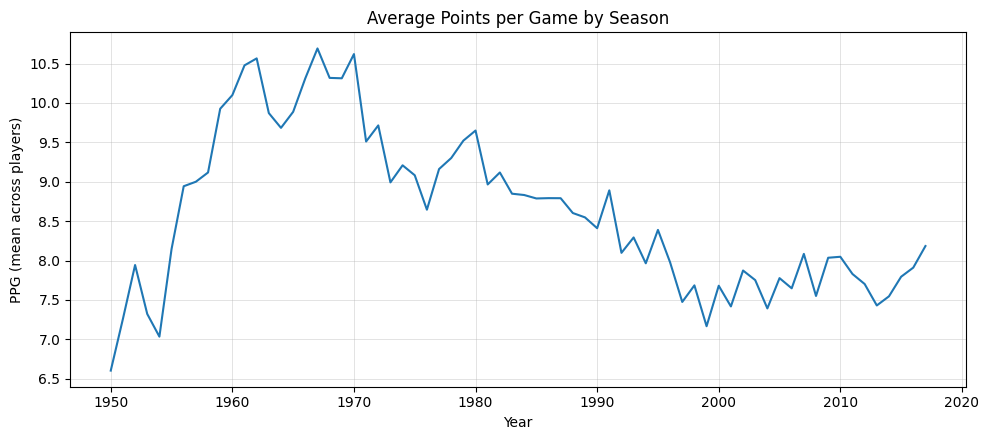

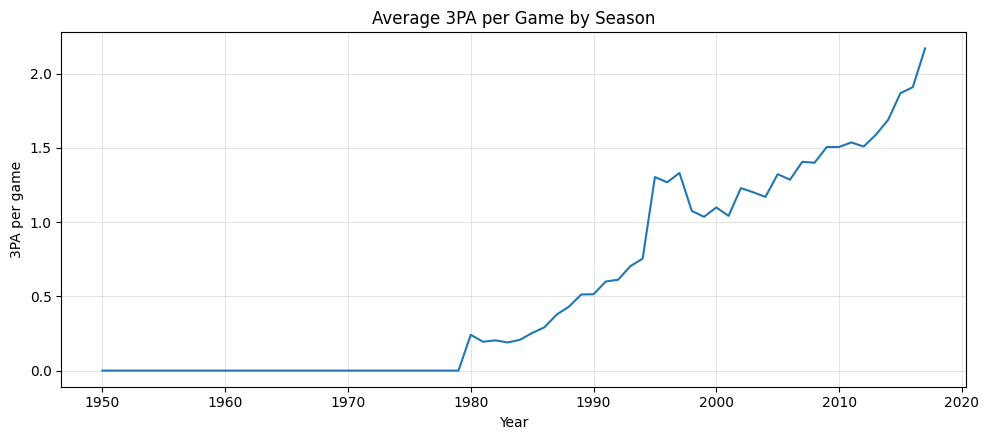

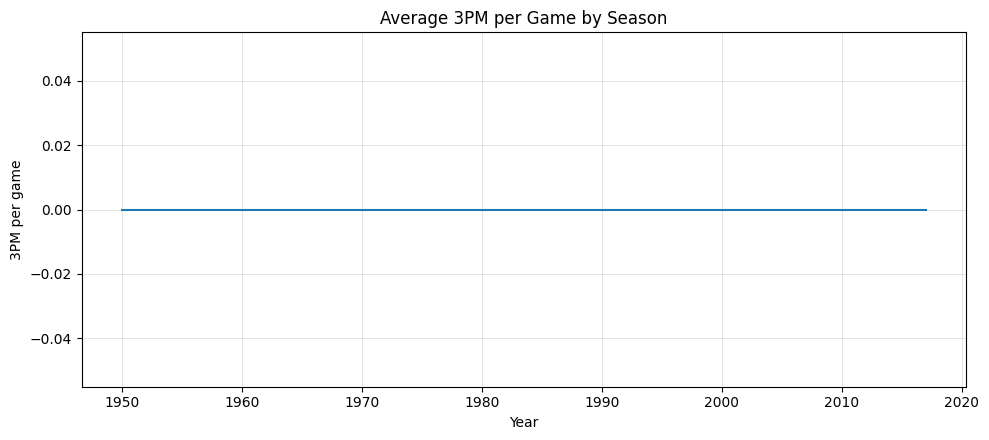

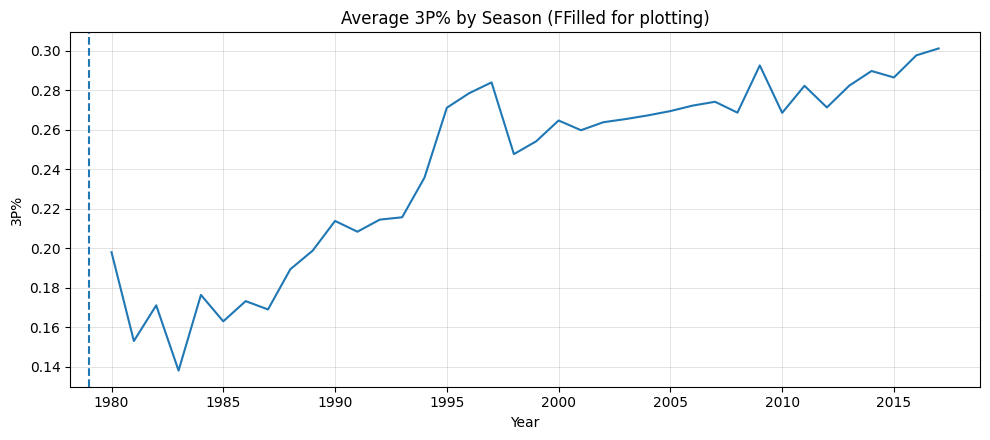

In [13]:

# Helper to make nice single-plot charts (no seaborn, no specific colors)
def simple_line(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10,4.5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

simple_line(agg['Year'], agg['PTS_per_game'], 
            "Average Points per Game by Season", "Year", "PPG (mean across players)")

simple_line(agg['Year'], agg['3PA_per_game'], 
            "Average 3PA per Game by Season", "Year", "3PA per game")

simple_line(agg['Year'], agg['3PM_per_game'], 
            "Average 3PM per Game by Season", "Year", "3PM per game")

# For 3P% use forward-filled version for smoother plotting, but annotate pre-1979 as undefined
years = agg['Year'].values
fg3_pct = agg_ffill['FG3_PCT'].values

plt.figure(figsize=(10,4.5))
plt.plot(years, fg3_pct)
plt.title("Average 3P% by Season (FFilled for plotting)")
plt.xlabel("Year")
plt.ylabel("3P%")
plt.grid(True, linewidth=0.5, alpha=0.5)
# Add vertical line for 1979 introduction of 3PT line
plt.axvline(x=1979, linestyle="--")
plt.tight_layout()
plt.show()


## 4) Relationship between 3PT volume and scoring
Check correlation between average 3PA per game and average PPG across seasons.

Correlation matrix:
               PTS_per_game  3PA_per_game  3PM_per_game
PTS_per_game      1.000000     -0.619562           NaN
3PA_per_game     -0.619562      1.000000           NaN
3PM_per_game           NaN           NaN           NaN
Linear model: PPG ≈ 9.166 + -0.962 * 3PA_per_game (R^2=0.384)


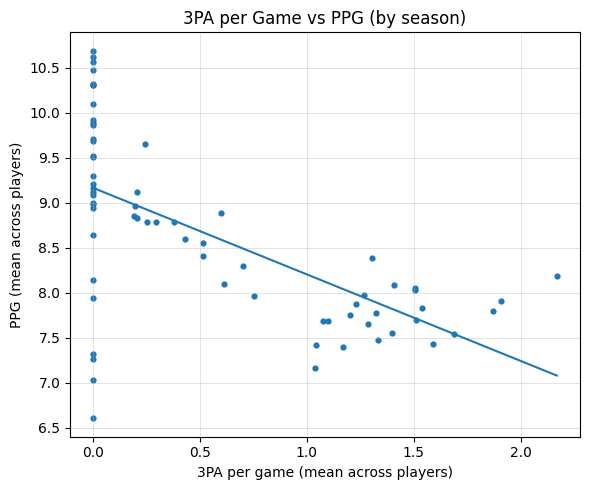

In [14]:

corr = agg[['PTS_per_game','3PA_per_game','3PM_per_game']].corr()
print("Correlation matrix:\n", corr)

# Simple scatter with regression using numpy polyfit
x = agg['3PA_per_game'].values.reshape(-1, 1)
y = agg['PTS_per_game'].values
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
slope = model.coef_[0]
intercept = model.intercept_
print(f"Linear model: PPG ≈ {intercept:.3f} + {slope:.3f} * 3PA_per_game (R^2={r2:.3f})")

plt.figure(figsize=(6,5))
plt.scatter(agg['3PA_per_game'], agg['PTS_per_game'], s=12)
x_line = np.linspace(agg['3PA_per_game'].min(), agg['3PA_per_game'].max(), 100).reshape(-1,1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line)
plt.title("3PA per Game vs PPG (by season)")
plt.xlabel("3PA per game (mean across players)")
plt.ylabel("PPG (mean across players)")
plt.grid(True, linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


## 5) Where the game is going — simple projections
We’ll fit a basic model on recent seasons (e.g., last 15 years) to project the next ~5 seasons for:
- Average 3PA per game
- Average PPG

This is a *toy* projection to illustrate trends, not a rigorous forecast. You can replace with more sophisticated time‑series models if desired.

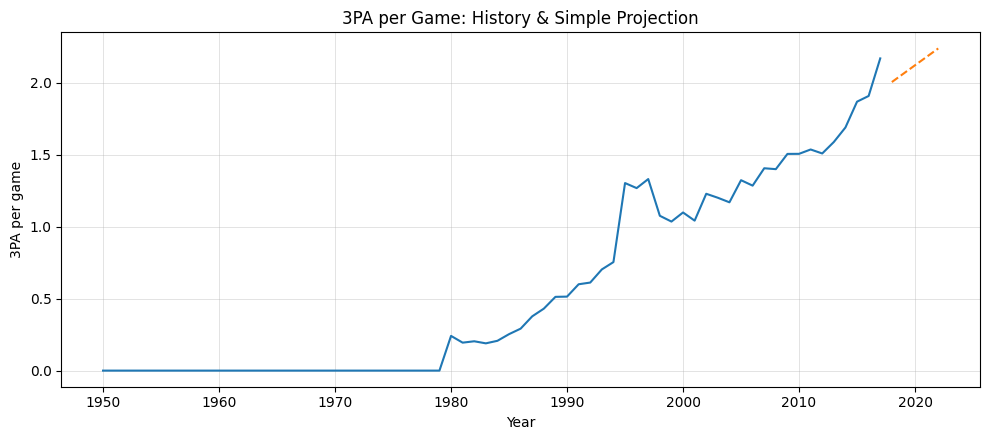

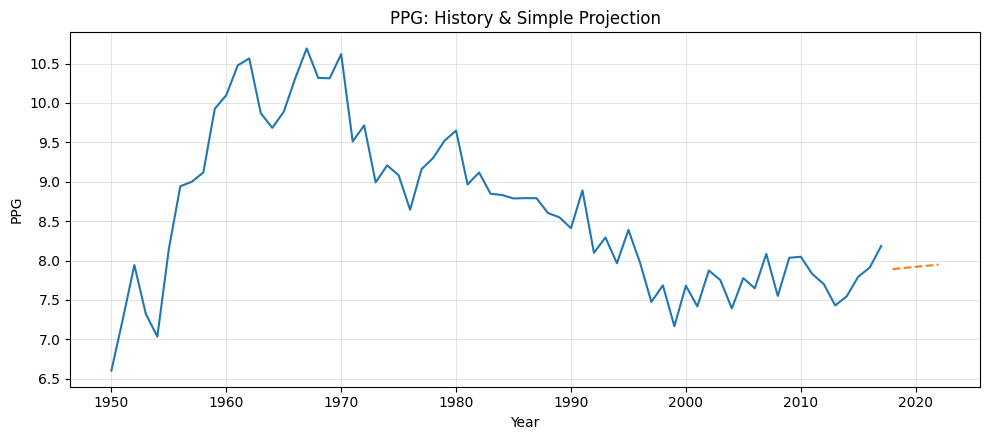

,Year,Projected_3PA_per_game,Projected_PPG
0,2018,2.005,7.892
1,2019,2.063,7.906
2,2020,2.122,7.920
3,2021,2.180,7.934
4,2022,2.239,7.948


OSError: Cannot save file into a non-existent directory: '\mnt\data\nba_scoring_3pt_evolution'

In [15]:

recent_window = 15  # number of last seasons to fit on
horizon = 5         # project next N seasons

df_recent = agg.sort_values('Year').tail(recent_window).copy()
X_year = df_recent['Year'].values.reshape(-1, 1)

# 3PA per game projection (linear)
y_3pa = df_recent['3PA_per_game'].values
model_3pa = LinearRegression().fit(X_year, y_3pa)

# PPG projection (linear). Could also fit PPG ~ 3PA as alternative
y_ppg = df_recent['PTS_per_game'].values
model_ppg = LinearRegression().fit(X_year, y_ppg)

last_year = int(agg['Year'].max())
future_years = np.arange(last_year+1, last_year+1+horizon).reshape(-1, 1)

pred_3pa = model_3pa.predict(future_years)
pred_ppg = model_ppg.predict(future_years)

# Plot history + projection
def plot_history_projection(years_hist, series_hist, years_future, series_future, title, ylabel):
    plt.figure(figsize=(10,4.5))
    plt.plot(years_hist, series_hist)
    plt.plot(years_future.flatten(), series_future, linestyle="--")
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.grid(True, linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_history_projection(agg['Year'].values, agg['3PA_per_game'].values,
                        future_years, pred_3pa,
                        "3PA per Game: History & Simple Projection", "3PA per game")

plot_history_projection(agg['Year'].values, agg['PTS_per_game'].values,
                        future_years, pred_ppg,
                        "PPG: History & Simple Projection", "PPG")

# Print numeric projection table
proj_df = pd.DataFrame({
    'Year': future_years.flatten(),
    'Projected_3PA_per_game': np.round(pred_3pa, 3),
    'Projected_PPG': np.round(pred_ppg, 3),
})
display(proj_df)

# Save projections
proj_csv = Path("/mnt/data/nba_scoring_3pt_evolution/projections.csv")
proj_df.to_csv(proj_csv, index=False)
print("Saved projections to:", proj_csv)


## 6) Key takeaways (template)
Update these bullet points after you run with your data:
- 3PT usage surged in the 2010s, with average 3PA per game increasing by **X%** since YEAR.
- Average 3P% has **stabilised around Y%** in the modern era.
- Average PPG has **risen/fallen** over the last Z seasons, likely driven by pace and spacing.
- Simple projections suggest **3PA per game** could reach **A** by **B**, and **PPG** could reach **C**.
- Implication: The game continues trending toward spacing and perimeter shooting; mid‑range remains de‑emphasised.